In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# Load data

In [2]:
df = pd.read_csv('spambase.data', header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [4]:
df.shape

(4601, 58)

In [5]:
### get the dummpy variable of labels
df = pd.get_dummies(df, columns=[57])

In [6]:
### check the missing values, there are no missing values in every variable.
sum(df.isnull().sum())

0

In [7]:
df_x  = df.iloc[:,:-2]
df_y = df.iloc[:, [-1,-2]]

In [8]:
## standardlize data
df_x_std = (df_x-df_x.mean()) / df_x.std()
df_x_std.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,-0.342396,0.330849,0.712781,-0.046894,0.011563,-0.350228,-0.291762,-0.262533,-0.323267,-0.371324,...,-0.111534,-0.158436,-0.514251,-0.155181,0.623939,-0.308321,-0.103037,-0.045242,0.045293,-0.008723
1,0.345322,0.051904,0.435082,-0.046894,-0.256089,0.672326,0.244717,-0.088001,-0.323267,1.086593,...,-0.111534,-0.158436,-0.026004,-0.155181,0.126189,0.423737,0.008762,-0.002443,0.250536,1.228191
2,-0.145906,-0.165054,0.851631,-0.046894,1.364698,0.343648,0.193623,0.036666,1.973802,0.016420,...,-0.111534,-0.117364,0.014683,-0.155181,0.008495,0.440005,-0.079746,0.145905,2.220865,3.258378
3,-0.342396,-0.165054,-0.556700,-0.046894,0.472521,-0.350228,0.500183,1.308259,0.789376,0.605791,...,-0.111534,-0.158436,-0.007510,-0.155181,-0.161917,-0.308321,-0.103037,-0.052144,-0.062459,-0.152205
4,-0.342396,-0.165054,-0.556700,-0.046894,0.472521,-0.350228,0.500183,1.308259,0.789376,0.605791,...,-0.111534,-0.158436,-0.014908,-0.155181,-0.164369,-0.308321,-0.103037,-0.052144,-0.062459,-0.152205


# ANN implementation with online learning

In [9]:
class Neural_Network():
    def __init__(self, input_dim, output_dim, learning_rate, max_iter, num_layer, num_nodes):
        # parameters
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.num_layer = num_layer
        self.num_nodes = num_nodes
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # initialize the weight matrix 
        self.W = [np.random.randn(self.input_dim, self.num_nodes)]  # input to hidden layer
        self.B = [np.zeros((1, self.num_nodes))]
        for _ in range(1, self.num_layer):
            self.W.append(np.random.randn(self.num_nodes,self.num_nodes))   # hidden layer to hidden layer
            self.B.append(np.zeros((1, self.num_nodes)))
        self.W.append(np.random.randn(self.num_nodes,self.output_dim))  # hiddern layer to output 
        self.B.append(np.zeros((1, self.output_dim)))      
    
    # activate method: sigmoid
    def sigmoid(self, s):
        return 1.0/(1 + np.exp(-s))
    def sigmod_prime(self, s):
        return s * (1-s)
    
    ## forward
    def forward(self, row):
        # input layer to output layer forward
        self.Z = [np.array(row).reshape(1, self.input_dim)]
        for i in range(0, len(self.W)):
            z = np.dot(self.Z[i], self.W[i]) + self.B[i]
            sz = self.sigmoid(z)
            self.Z.append(sz)
        # return output
        return self.Z[-1]
    
    # backward
    def backward(self,Y, output):
        self.deltaZ = [(output-Y) * self.sigmod_prime(output)]
        self.deltaW = []
        self.deltaB = []
        for i in range(len(self.W)-1,-1,-1):
            deltaW = np.dot(self.Z[i].T, self.deltaZ[-1])
            self.deltaW = [deltaW] + self.deltaW
            deltaB = np.sum(self.deltaZ[-1], axis=0)
            self.deltaB = [deltaB] + self.deltaB
            
            # add backward deltaZ in self.Z
            dz = np.multiply((self.deltaZ[-1] @ self.W[i].T), self.sigmod_prime(self.Z[i]))
            self.deltaZ.append(dz)
        
        # update the parameters
        for i in range(len(self.W)):
            self.W[i] += -1*self.learning_rate*self.deltaW[i]
            self.B[i] += -1*self.learning_rate*self.deltaB[i]
    
    # train the data 
    def train(self, train_x, train_y, print_loss=False):
        self.train_x = train_x
        self.train_y = train_y

        for n in range(self.max_iter):         
            #### online training 
            for i in range(len(self.train_x)):
                output  = np.array(self.forward(train_x[i]))
                self.backward(np.array(train_y[i]), output)
                
            # Forward propogation to calculate the predictions
            if print_loss:
                losses = []
                for i in range(len(train_x)):
                    loss =- np.sum(train_y[i] * np.log(self.forward(train_x[i])))
                    losses.append(loss)
                print("Loss after iteration %i: %f" %(i, np.sum(losses) / len(train_x)))
                
    def predict(self, val_x):
        # Do forward pass
        predictions = []
        for i in range(len(val_x)):
            pred = self.forward(val_x[i])
            #get y_hat
            y_hat = np.argmax(pred, axis=1)
            predictions.append(y_hat[0])
        return np.array(predictions)
    
    def accuracy_score(self,pred,y):
        # Get total number of examples
        m = y.shape[0]
        y_true = y.argmax(axis=1)
        # Calculate the number of wrong examples
        error = np.sum(np.abs(pred-y_true)) 
        # Calculate accuracy
        return (m-error) / m

# Run algorithm

In [10]:
## random split data, training dataset (80%) and test dataset (20%)
from sklearn.model_selection import train_test_split
import random

## data
X = np.array(df_x_std)
Y = np.array(df_y)

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2)

In [11]:
## run k-folder cross validation function 
def cv_train_test_split(X, Y, kfolder= 10):
    X_split, Y_split = [], []
    index = list(range(len(Y)))
    random.shuffle(index)   ## shuffle the index to random select
    fold_size = int(len(X) / kfolder) + (len(X)%kfolder > 0)
    for i in range(kfolder):
        X_fold = X[index[i*fold_size: (i+1)*fold_size]]
        Y_fold = Y[index[i*fold_size: (i+1)*fold_size]]
        X_split.append(X_fold)
        Y_split.append(Y_fold)
    return X_split, Y_split

In [12]:
# data split
nn_X, nn_Y = cv_train_test_split(train_x, train_y)

In [13]:
## run the cross validation function 
def cv_nn(X, Y, input_dim, output_dim, learning_rate, max_iter, num_layer, num_nodes):
    scores = []
    for i in range(10):
        x_train, x_test = np.concatenate(X[:i] + X[i+1:], axis = 0), X[i]
        y_train, y_test = np.concatenate(Y[:i] + Y[i+1:], axis = 0), Y[i]
        NN = Neural_Network(input_dim, output_dim, learning_rate, max_iter, num_layer, num_nodes)
        NN.train(x_train, y_train)
        pred = NN.predict(x_test)
        scores.append(NN.accuracy_score(pred, y_test))
    return sum(scores)/len(scores)

In [15]:
## tune the parameters: 1. max_iter   2. learning rate
# specified parameters, to simplify we choose to have one hidden layer with 5 neurons.
input_dim = train_x.shape[1]
output_dim = 2
num_layer = 1
num_nodes = 5


# unspecifies parameters
learning_rates = [ 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
max_iters = list(range(5, 55,5))
score_matrix = np.zeros((len(learning_rates), len(max_iters)))

for l in range(len(learning_rates)):
    for m in range(len(max_iters)):
        learning_rate, max_iter = learning_rates[l], max_iters[m]
        accu = cv_nn(nn_X, nn_Y, input_dim, output_dim, learning_rate, max_iter, num_layer, num_nodes)
        print('The accuracy score for %f, %d is %.4f' %(learning_rate, max_iter, accu))
        score_matrix[l, m] = accu

The accuracy score for 0.001000, 5 is 0.5878
The accuracy score for 0.001000, 10 is 0.6538
The accuracy score for 0.001000, 15 is 0.7212
The accuracy score for 0.001000, 20 is 0.7389
The accuracy score for 0.001000, 25 is 0.7462
The accuracy score for 0.001000, 30 is 0.7658
The accuracy score for 0.001000, 35 is 0.8071
The accuracy score for 0.001000, 40 is 0.7970
The accuracy score for 0.001000, 45 is 0.8095
The accuracy score for 0.001000, 50 is 0.8378
The accuracy score for 0.005000, 5 is 0.7454
The accuracy score for 0.005000, 10 is 0.8217
The accuracy score for 0.005000, 15 is 0.8633
The accuracy score for 0.005000, 20 is 0.8834
The accuracy score for 0.005000, 25 is 0.8970
The accuracy score for 0.005000, 30 is 0.9024
The accuracy score for 0.005000, 35 is 0.8978
The accuracy score for 0.005000, 40 is 0.9125
The accuracy score for 0.005000, 45 is 0.9130
The accuracy score for 0.005000, 50 is 0.9139
The accuracy score for 0.010000, 5 is 0.8177
The accuracy score for 0.010000, 10 i

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


The accuracy score for 1.000000, 30 is 0.9236
The accuracy score for 1.000000, 35 is 0.9296
The accuracy score for 1.000000, 40 is 0.9247
The accuracy score for 1.000000, 45 is 0.9332
The accuracy score for 1.000000, 50 is 0.9288


In [16]:
## heatmap
def plotHeatMap(data, x_title='X Axis', y_title='Y Axis', title='', x_ticks=[], y_ticks=[]):
    
    #Plot it out
    fig, ax = plt.subplots()
    ax = plt.gca()
    heatmap = ax.pcolor(data, edgecolors='k', alpha=0.8)
    
    fig.colorbar(heatmap, ax=ax)
    
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(len(x_ticks)) + 0.5, minor=False)
    ax.set_yticks(np.arange(len(y_ticks)) + 0.5, minor=False)
    
    ax.set_xticklabels([str(i) for i in x_ticks], minor=False)
    ax.set_yticklabels([str(y) for y in y_ticks], minor=False)
    
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)
    
    plt.show()

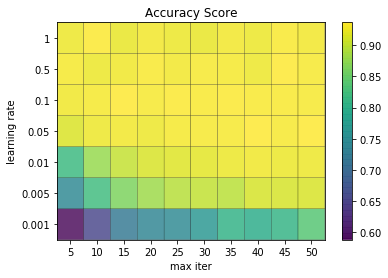

In [17]:
plotHeatMap(score_matrix, y_title='learning rate', x_title='max iter',\
            title='Accuracy Score', y_ticks=learning_rates, x_ticks=max_iters)

In [18]:
np.argmax(score_matrix)

42

In [19]:
def confusion_matrix(pred, y):
    m = y.shape[0]
    y_true = y.argmax(axis=1)
    
    FP = sum((y_true==0) & (pred==1))
    FN = sum((y_true==1) & (pred==0))
    TP = sum((y_true==1) & (pred==1))
    TN = sum((y_true==0) & (pred==0))
    
    ## print performance metrics
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    TPR = TP / (TP + FN)
    PPV = TP / (TP + FP)
    TNR = TN / (TN + FP)
    F1_score = 2*PPV*TPR / (PPV+TPR)
    metric = pd.DataFrame([accuracy, TPR, PPV, TNR, F1_score], ['ACCU', 'TPR', 'PPV', 'TNR', 'F1'], ['score'])
    
    ### print confusion matrix
    conf_matrix = np.array([[TP, FN], [FP, TN]])
    conf = pd.DataFrame(conf_matrix, ['spam', 'not spam'], ['spam', 'not spam'])
    return metric, conf

In [20]:
## find the optimum learning_rate and max_iter, train the training data and test the test_data
learning_rate, max_iter = 0.1, 15
NN = Neural_Network(input_dim, output_dim, learning_rate, max_iter, num_layer, num_nodes)
NN.train(train_x, train_y, print_loss=True)
pred = NN.predict(test_x)
# metrics 
metric, confusion = confusion_matrix(pred, test_y)
print(metric)
print(confusion)

Loss after iteration 3679: 0.337720
Loss after iteration 3679: 0.256780
Loss after iteration 3679: 0.230917
Loss after iteration 3679: 0.214420
Loss after iteration 3679: 0.205818
Loss after iteration 3679: 0.199897
Loss after iteration 3679: 0.196530
Loss after iteration 3679: 0.191665
Loss after iteration 3679: 0.188837
Loss after iteration 3679: 0.186674
Loss after iteration 3679: 0.184102
Loss after iteration 3679: 0.182587
Loss after iteration 3679: 0.181700
Loss after iteration 3679: 0.180042
Loss after iteration 3679: 0.180500
         score
ACCU  0.927253
TPR   0.925795
PPV   0.954463
TNR   0.929577
F1    0.939910
          spam  not spam
spam       524        42
not spam    25       330


# ANNs with Reduced Dimension

In [21]:
## run pca analysis, get the principle components, the first 43 components (90% of variance)
u, s, vh = np.linalg.svd(df_x_std)

s2 = np.cumsum(s**2) / np.sum(s**2)
print(s2)

[0.11564794 0.17297118 0.2081142  0.23641524 0.26354169 0.28920029
 0.314007   0.33812839 0.36085269 0.38325521 0.4046048  0.42443115
 0.4439361  0.46314837 0.48221912 0.50087647 0.51927371 0.53722774
 0.55499377 0.57258701 0.59005918 0.60722171 0.62414334 0.64065816
 0.65708953 0.67330598 0.68936487 0.70523575 0.72055892 0.73575189
 0.75042723 0.7649313  0.77892553 0.79263965 0.80626455 0.81951942
 0.83239801 0.84508326 0.85744449 0.86954722 0.88138239 0.8930665
 0.90392819 0.91460277 0.92481097 0.93493523 0.94413616 0.95271015
 0.96061065 0.96778785 0.97437741 0.98079342 0.98666807 0.99202564
 0.99659442 0.99993237 1.        ]


In [22]:
pc_x = df_x_std @ vh.T[:, :43]

In [23]:
## data
X_PC = np.array(pc_x)
Y_PC = np.array(df_y)

pca_train_x, pca_test_x, pca_train_y, pca_test_y = train_test_split(X_PC, Y_PC, test_size=0.2)

In [24]:
# data split
nn_pca_X, nn_pca_Y = cv_train_test_split(pca_train_x, pca_train_y)

In [25]:
## tune the parameters: 1. max_iter   2. learning rate
# specified parameters, to simplify we choose to have one hidden layer with 5 neurons.
pca_input_dim = pca_train_x.shape[1]
output_dim = 2
num_layer = 1
num_nodes = 5


# unspecifies parameters
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
max_iters = list(range(5, 55,5))
pca_score_matrix = np.zeros((len(learning_rates), len(max_iters)))

for l in range(len(learning_rates)):
    for m in range(len(max_iters)):
        learning_rate, max_iter = learning_rates[l], max_iters[m]
        accu = cv_nn(nn_pca_X, nn_pca_Y, pca_input_dim, output_dim, learning_rate, max_iter, num_layer, num_nodes)
        print('The accuracy score for %f, %d is %.4f' %(learning_rate, max_iter, accu))
        pca_score_matrix[l, m] = accu

The accuracy score for 0.001000, 5 is 0.6141
The accuracy score for 0.001000, 10 is 0.6970
The accuracy score for 0.001000, 15 is 0.6796
The accuracy score for 0.001000, 20 is 0.7429
The accuracy score for 0.001000, 25 is 0.7717
The accuracy score for 0.001000, 30 is 0.7793
The accuracy score for 0.001000, 35 is 0.8027
The accuracy score for 0.001000, 40 is 0.8394
The accuracy score for 0.001000, 45 is 0.8296
The accuracy score for 0.001000, 50 is 0.8378
The accuracy score for 0.005000, 5 is 0.7772
The accuracy score for 0.005000, 10 is 0.8492
The accuracy score for 0.005000, 15 is 0.8810
The accuracy score for 0.005000, 20 is 0.8970
The accuracy score for 0.005000, 25 is 0.8997
The accuracy score for 0.005000, 30 is 0.9043
The accuracy score for 0.005000, 35 is 0.9158
The accuracy score for 0.005000, 40 is 0.9128
The accuracy score for 0.005000, 45 is 0.9212
The accuracy score for 0.005000, 50 is 0.9158
The accuracy score for 0.010000, 5 is 0.8470
The accuracy score for 0.010000, 10 i

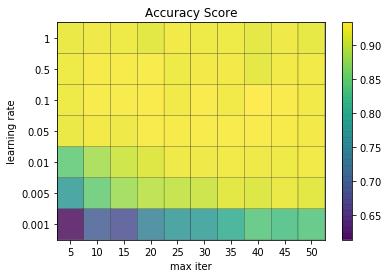

In [26]:
plotHeatMap(pca_score_matrix, y_title='learning rate', x_title='max iter',\
            title='Accuracy Score', y_ticks=learning_rates, x_ticks=max_iters)

In [27]:
np.argmax(pca_score_matrix)

47

In [28]:
## find the optimum learning_rate and max_iter, train the training data and test the test_data
learning_rate, max_iter = 0.1, 40
NN = Neural_Network(pca_input_dim, output_dim, learning_rate, max_iter, num_layer, num_nodes)
NN.train(pca_train_x, pca_train_y, print_loss=True)
pred = NN.predict(pca_test_x)
# metrics 
metric, confusion = confusion_matrix(pred, pca_test_y)
print(metric)
print(confusion)

Loss after iteration 3679: 0.307076
Loss after iteration 3679: 0.257007
Loss after iteration 3679: 0.238259
Loss after iteration 3679: 0.226222
Loss after iteration 3679: 0.218667
Loss after iteration 3679: 0.215279
Loss after iteration 3679: 0.212506
Loss after iteration 3679: 0.210777
Loss after iteration 3679: 0.208499
Loss after iteration 3679: 0.207035
Loss after iteration 3679: 0.205912
Loss after iteration 3679: 0.205105
Loss after iteration 3679: 0.203139
Loss after iteration 3679: 0.202159
Loss after iteration 3679: 0.202525
Loss after iteration 3679: 0.200162
Loss after iteration 3679: 0.199067
Loss after iteration 3679: 0.197952
Loss after iteration 3679: 0.198262
Loss after iteration 3679: 0.196253
Loss after iteration 3679: 0.195053
Loss after iteration 3679: 0.193841
Loss after iteration 3679: 0.194410
Loss after iteration 3679: 0.192610
Loss after iteration 3679: 0.191692
Loss after iteration 3679: 0.191209
Loss after iteration 3679: 0.190269
Loss after iteration 3679: 0